In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
env = BlackjackEnv()

In [4]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [5]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        action_values = Q[observation]
        action_probs = np.zeros_like(action_values, dtype=float)
        a = np.argmax(action_values)
        action_probs[a] = 1.0
        return action_probs

    return policy_fn

In [20]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """

    # Weighted importance sampling computes the following:
    # \frac{/sum_i /W_i /G-i}{/sum_i /W_i}, where W are the importance weights
    # The expectation of numerator is just the expected target return
    # The expectation of the denominator is 1, that is, the expectation of the importance weights is 1
    # Because we can expand the importance weights into the target policy probability divided by
    # the behavior policy probability for a trajectory. And taking the expectation under the behavior
    # policy distribution cancels the denominator.
    # Weighted importance sampling exhibits the benefit of reduced variance, because a huge W will not
    # have as big an impact on the result
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The sum of all current importance weights
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for i in range(num_episodes):
        episode = []

        observation = env.reset()
        while True:
            action_distribution = behavior_policy(observation)
            action = np.random.choice(len(action_distribution), p=action_distribution)
            new_observation, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            if done:
                break
            observation = new_observation

        cur_behavior_return = 0
        cur_importance_weight = 1
        for j in range(len(episode) - 1, -1, -1):
            o, a, r_behavior = episode[j]
            cur_behavior_return = discount_factor * cur_behavior_return + r_behavior
            cur_importance_weight *= target_policy(o)[a] / behavior_policy(o)[a]
            if cur_importance_weight == 0:
                break

            # Might also implement incrementally
            Q[o][a] = (Q[o][a] * C[o][a] + cur_behavior_return * cur_importance_weight) / (C[o][a] + cur_importance_weight)
            C[o][a] += cur_importance_weight
        
    return Q, target_policy

In [24]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=1000000, behavior_policy=random_policy)

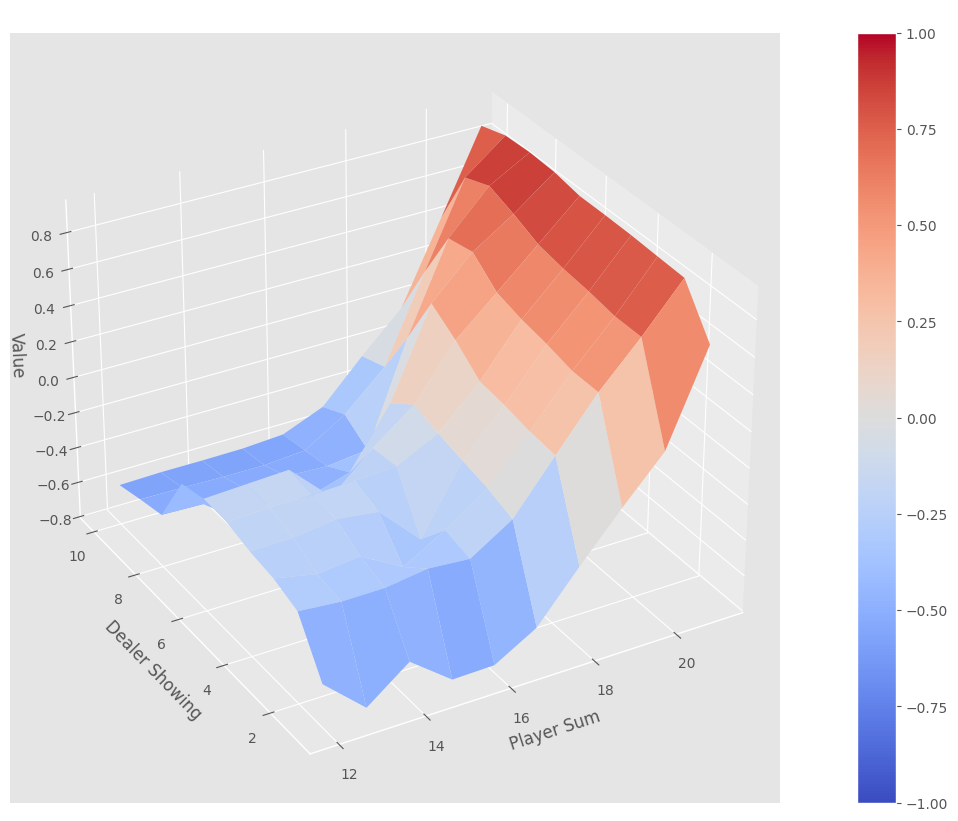

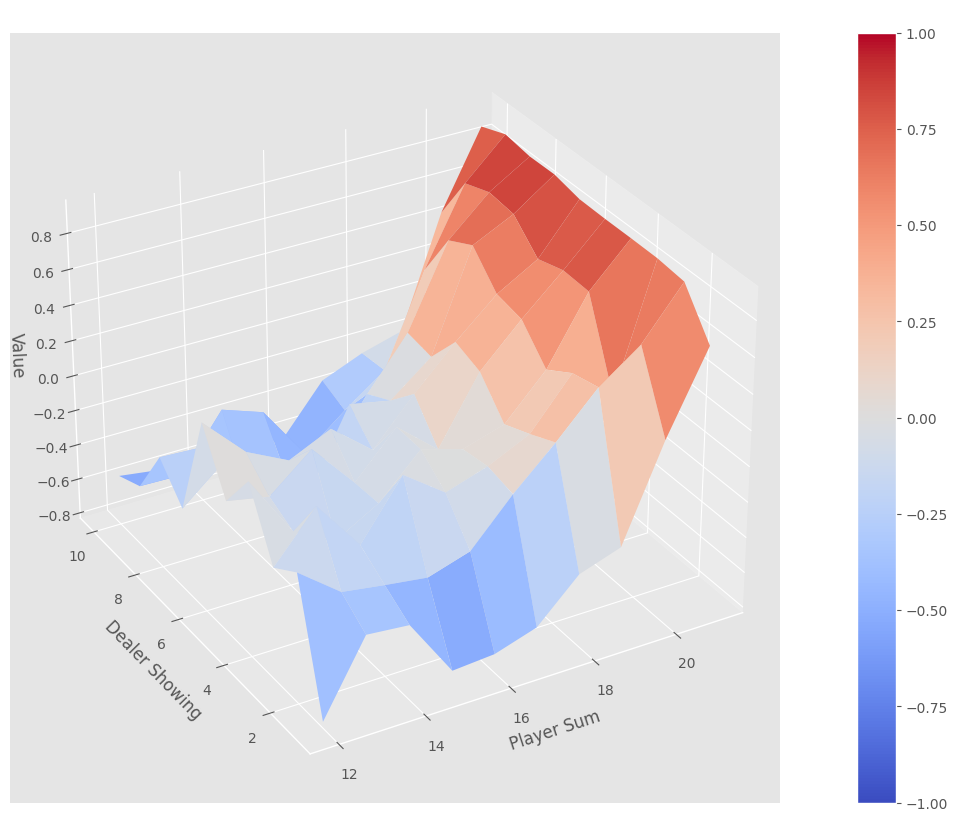

In [25]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")